In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import pickle
pd.options.display.max_rows = 6000

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models, similarities, matutils
import nltk
from nltk.stem import WordNetLemmatizer
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Data cleaning

__Data overview__<br>
-  the data set has 5911 speech from 12 debates from June 26, 2019 to Feb 25, 2020. 
-  106 people, including host, audience and the candidates

__Cleaning steps__<br>
-  remove 516 rows whose speaking time is none
-  filter in only the candidates whose total speaking time is more than 20 minutes. 13 candidates are left.
-  create a new dataframe: every sentence is a seperate row
-  basic cleaning of each row: remove numbers, remove punctuations, lower all letters
-  filter out the rows with less than 25 space: most of empty space cells and non meaningful sentences are ruled out.
-  set the date column to datetime format
-  a new dataframe!

In [2]:
df = pd.read_csv('/Users/peiguo/Documents/Metis/metis-projects/Project4/project4-githubfolder/debate_transcripts_v3_2020-02-26.csv', encoding = 'windows-1252')

In [3]:
df.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Good evening and welcome, the Democratic presi...",8.0
1,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And Super Tuesday is just a week away and this...,22.0
2,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,And CBS News is proud to bring you this debate...,14.0
3,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And we are partnering tonight also with Twitte...,10.0
4,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Now, here are the rules for the next two hours...",31.0


In [4]:
df.date.unique()

array(['02-25-2020', '02-19-2020', '02-07-2020', '01-14-2020',
       '12-19-2019', '11-20-2019', '10-15-2019', '09-12-2019',
       '07-31-2019', '07-30-2019', '06-27-2019', '06-26-2019'],
      dtype=object)

In [5]:
df.debate_name.unique()

array(['South Carolina Democratic Debate Transcript: February 25 Democratic Debate',
       'Democratic Debate Transcript: Las Vegas, Nevada Debate',
       'New Hampshire Democratic Debate Transcript',
       'January Iowa Democratic Debate Transcript',
       'December Democratic Debate Transcript: Sixth Debate from Los Angeles',
       'November Democratic Debate Transcript – 5th Debate Transcript from Atlanta',
       'October Democratic Debate Transcript: 4th Debate in Ohio',
       'September Houston Democratic Debate Transcript – Third Debate',
       'Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019',
       'Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019',
       'Transcript from Night 2 of the First 2019 June Democratic Debates',
       'Transcript from Night 1 of the 2019 June Democratic Debates'],
      dtype=object)

In [6]:
df.speaker.unique()

array(['Norah O’Donnell', 'Gayle King', 'Bernie Sanders',
       'Michael Bloomberg', 'Pete Buttigieg', 'Elizabeth Warren',
       'Tom Steyer', 'Joe Biden', 'Amy Klobuchar', 'Bill Whitaker',
       'Major Garrett', 'Speaker 1', 'Margaret Brennan', 'Lester Holt',
       'Hallie Jackson', 'Chuck Todd', 'Female', 'Moderator',
       'Vanessa Hauc', 'Jon Ralston', 'Helen', 'Moderator 1',
       'Moderator 4', 'Audience', 'George S.', 'Andrew Yang',
       'Linsey Davis', 'David Muir', 'Monica Hernandez', 'Adam Sexton',
       'Devin Dwyer', 'Rachel Scott', 'Announcer', 'Wolf Blitzer',
       'Abby Phillips', 'B. Pfannenstiel', 'Moderator 2', 'Brianne P.',
       'Judy Woodruff', 'Amy Walter', 'Stephanie Sy', 'Speaker 2',
       'Tim Alberta', 'Amna Nawaz', 'Yamiche A.', 'Rachel Maddow',
       'Andrea Mitchell', 'Kamala Harris', 'Cory Booker',
       'Kristen Welker', 'Ashley Parker', 'Tulsi Gabbard', 'Speaker 3',
       'Anderson Cooper', 'Erin Burnett', 'Marc Lacey', 'Julian Castro',
  

In [7]:
df.info()
# speaking_time_seconds has hunderds of none values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 6 columns):
date                     5911 non-null object
debate_name              5911 non-null object
debate_section           5911 non-null object
speaker                  5911 non-null object
speech                   5911 non-null object
speaking_time_seconds    5395 non-null float64
dtypes: float64(1), object(5)
memory usage: 277.2+ KB


In [8]:
#df.isna().sum()
df.dropna(inplace = True)   # remove rows with none value
df.reset_index(drop=True, inplace = True)

# filter in only the candidate whose total speaking time is more than 20 minutes.
df = df.groupby(df.speaker).filter(lambda x: x.speaking_time_seconds.sum() > 1200)
df.reset_index(drop=True, inplace = True)
df.speaker.unique()

array(['Bernie Sanders', 'Michael Bloomberg', 'Pete Buttigieg',
       'Elizabeth Warren', 'Tom Steyer', 'Joe Biden', 'Amy Klobuchar',
       'Andrew Yang', 'Kamala Harris', 'Cory Booker', 'Tulsi Gabbard',
       'Julian Castro', 'Beto O’Rourke'], dtype=object)

In order to analyze the sentence sentiment, we need to have one sentence in each row. <br>
The functions below will create a new dataframe which is grouped by dates and speakers, and has one sentence each row.

In [9]:
namelist = df.speaker.unique()
datelist = df.date.unique()

def df_speaker_sentence(date, name):
    '''
    create a dataframe that has three columns: date, speaker name and sentences.
    each row has one sentence from this speaker on this date.
    '''
    df_speaker_sentence = pd.DataFrame()
    person_speech = df.loc[(df.speaker == name) & (df.date == date)].speech   # if the name is not there, will return an empty series.
    if not person_speech.empty:   # check if a dataframe/series is empty. because some speakers did not show up in certain debates           
        text = ''
        for speech in person_speech:
            text = text +' ' + speech  # a long string has all the speech from this speaker
        list_sent = nltk.tokenize.sent_tokenize(text) # split the entire speech into a list of sentences
        list_date = [date]*len(list_sent)
        list_speaker = [name]*len(list_sent)
        df_speaker_sentence['date'] = list_date
        df_speaker_sentence['speaker'] = list_speaker
        df_speaker_sentence['sentence'] = list_sent 
        return df_speaker_sentence

def df_date_skeaker_sentence(date, namelist):
    '''
    create a dataframe that has 3 columns: date, speaker, sentences.
    date column only has one date from the input, the speaker column is grouped by the namelist.
    each speaker's each sentence has its own row.
    '''
    df_all_speaker = pd.DataFrame()
    for name in namelist:
        df_name = df_speaker_sentence(date, name)
        if df_name is not None:
            df_all_speaker = pd.concat([df_all_speaker, df_name], ignore_index = True) # concat an empty df and a df
        else:continue
    return df_all_speaker
    
def df_speech_to_sentence(namelist, datelist):
    '''
    This function extends the dataframe from the df_date_skeaker_sentence function.
    It has all the dates, grouped by dates. 
    Within each dates section, the speaker column is grouped by speakers.
    Each sentence of the speaker has its own row. 
    '''
    df_speech_to_sentence = pd.DataFrame()
    for date in datelist:
        df_date = df_date_skeaker_sentence(date, namelist)
        df_speech_to_sentence = pd.concat([df_speech_to_sentence,df_date],ignore_index = True)
    return df_speech_to_sentence

In [10]:
df = df_speech_to_sentence(namelist, datelist)
df.head()

,date,speaker,sentence
0,02-25-2020,Bernie Sanders,"Well, you’re right, the economy is doing real..."
1,02-25-2020,Bernie Sanders,"In the last three years, last three years, bil..."
2,02-25-2020,Bernie Sanders,"But you know what, for the ordinary American t..."
3,02-25-2020,Bernie Sanders,"Last year, real wage increases for the average..."
4,02-25-2020,Bernie Sanders,Half of our people are living paycheck to payc...


In [12]:
# remove words with numbers
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x) 

# remove punctuations and lower the letters
punc_lower = lambda x: re.sub('[%s]' % re.escape('!"“"”#$%&\'’()*+,-./:;<=>?@[\\]^_`{|}~'), ' ', x.lower())
df.sentence = df.sentence.map(alphanumeric).map(punc_lower)

# remove rows with sentences length less than 25 characters, because short sentence are meaningless for sentiment analysis and topic modelling.
df = df[df.sentence.str.len() > 25]

In [13]:
df.date = pd.to_datetime(df.date).dt.date

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9793 entries, 0 to 11222
Data columns (total 3 columns):
date        9793 non-null object
speaker     9793 non-null object
sentence    9793 non-null object
dtypes: object(3)
memory usage: 306.0+ KB


In [15]:
df.head()

,date,speaker,sentence
0,2020-02-25,Bernie Sanders,well you re right the economy is doing real...
1,2020-02-25,Bernie Sanders,in the last three years last three years bil...
2,2020-02-25,Bernie Sanders,but you know what for the ordinary american t...
3,2020-02-25,Bernie Sanders,last year real wage increases for the average...
4,2020-02-25,Bernie Sanders,half of our people are living paycheck to payc...


In [16]:
with open('df_sentence', 'wb') as to_write:
    pickle.dump(df, to_write)

In [17]:
with open ('df_sentence', 'rb') as to_read:
    df = pickle.load(to_read)

In [18]:
df.shape

(9793, 3)

# Most used words per candidate?

In [19]:
df.speaker.unique()

array(['Bernie Sanders', 'Michael Bloomberg', 'Pete Buttigieg',
       'Elizabeth Warren', 'Tom Steyer', 'Joe Biden', 'Amy Klobuchar',
       'Andrew Yang', 'Kamala Harris', 'Cory Booker', 'Tulsi Gabbard',
       'Julian Castro', 'Beto O’Rourke'], dtype=object)

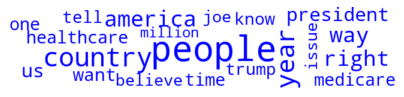

In [21]:
# a long string with all the speech from this person
df_person = df[df.speaker=='Bernie Sanders'] 
text = " ".join(sentence for sentence in df_person.sentence)


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# use the stopwords from wordcloud + my own words
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors",'going','re','say','got','don',
                  'let','ve','city','need','make','sure','think','every','will','united','states',
                 'mr','well','done', 'two','ago','thing','first','number','around','american'])

# a mask to make every word cloud picture has a long rectangular shape, like the ribbons of the USA flag
maskred = np.array(Image.open("pictures/redbar.png")) 

#generate the word cloud with customized parameters
wordcloud = WordCloud(color_func=lambda *args, **kwargs: "blue", background_color="white", 
                      max_words=20, stopwords=stopwords, mask=maskred).generate(text)


plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("B_San.png", format="png")
plt.show()

# Sentiment change per candidate over all debates?

In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df['sentiment'] = np.nan
analyser = SentimentIntensityAnalyzer()
df.sentiment = df.sentence.apply(lambda x: analyser.polarity_scores(x))

df['senti_comp'] = np.nan
df.senti_comp = df.sentiment.apply(lambda x: x['compound'])

df.head()

,date,speaker,sentence,sentiment,senti_comp
0,2020-02-25,Bernie Sanders,well you re right the economy is doing real...,"{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",0.8399
1,2020-02-25,Bernie Sanders,in the last three years last three years bil...,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.6705
2,2020-02-25,Bernie Sanders,but you know what for the ordinary american t...,"{'neg': 0.252, 'neu': 0.748, 'pos': 0.0, 'comp...",-0.6178
3,2020-02-25,Bernie Sanders,last year real wage increases for the average...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,2020-02-25,Bernie Sanders,half of our people are living paycheck to payc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


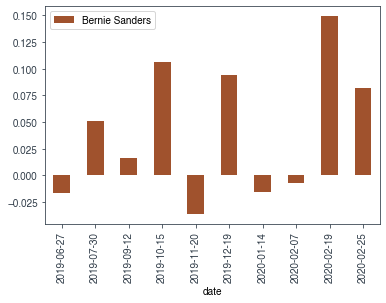

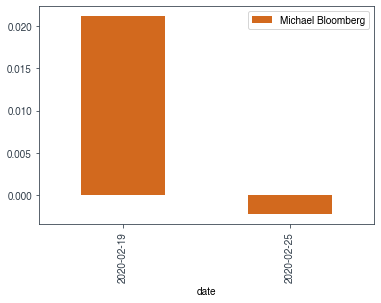

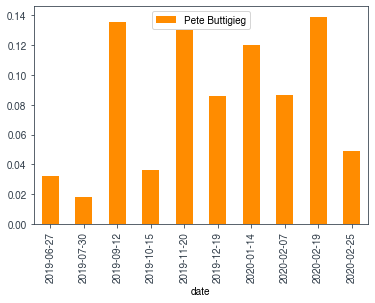

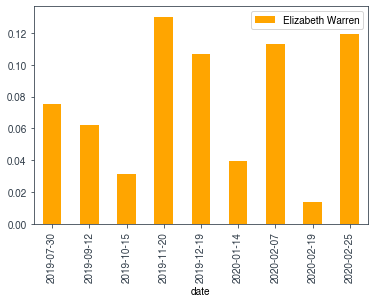

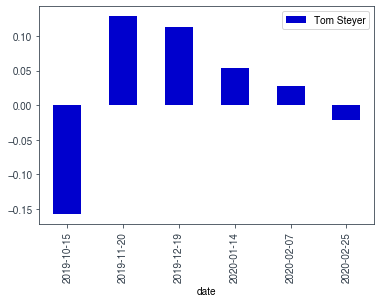

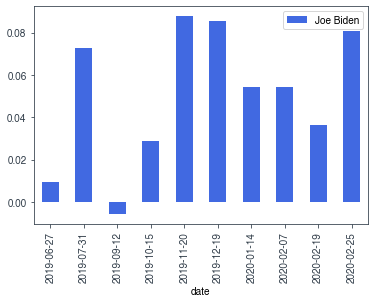

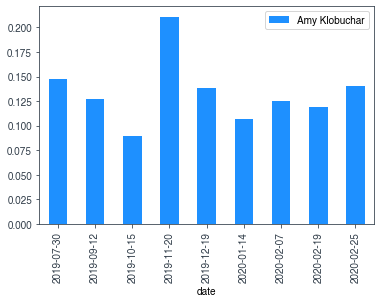

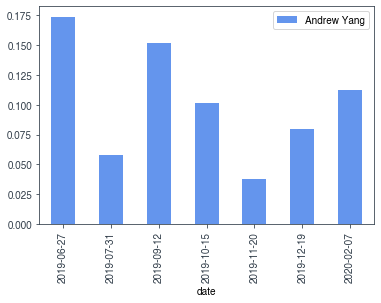

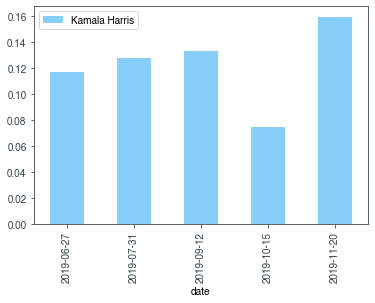

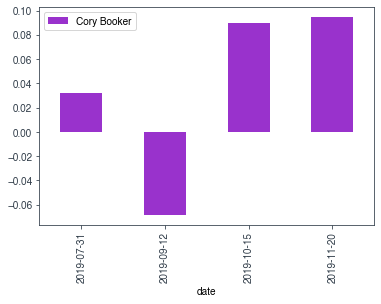

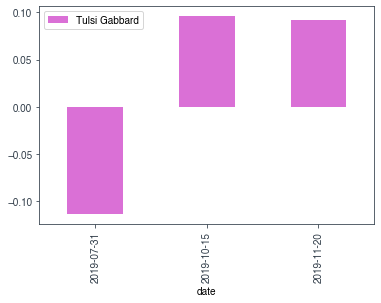

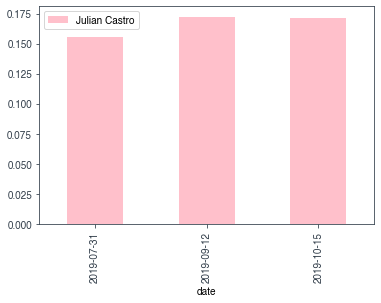

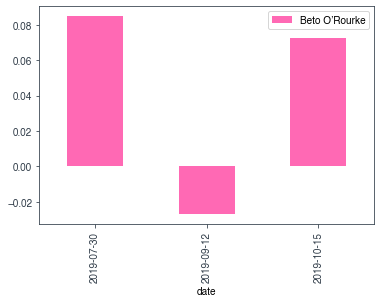

In [70]:
colorlist = ['sienna','chocolate','darkorange','orange','mediumblue','royalblue','dodgerblue','cornflowerblue','lightskyblue','darkorchid','orchid','pink','hotpink']
for name, color in zip(df.speaker.unique(), colorlist):
    plt.figure()
    plt.rcParams['font.family'] = 'sans-serif'
    df[df.speaker == name].groupby('date').senti_comp.mean().plot.bar(label = name, color = color )
    plt.legend() #bbox_to_anchor=(1, 1)
    plt.savefig("{}-sentiment.png".format(name), format="png", bbox_inches='tight')

# Preparation for modeling

In [71]:
# Lemmatation
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    lemmas = []
    for item in tokens:
        lemmas.append(WordNetLemmatizer().lemmatize(item))
    return lemmas

In [72]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [74]:
# for stopwords

#get the stop words from sklearn
from sklearn.feature_extraction import stop_words
sk_stop = list(stop_words.ENGLISH_STOP_WORDS)
sk_stop_remove = ['thick','amount','former','bill','sincere','bottom','thin','system','fire','cry','across','mill','interest']
my_sk_stop = [item for item in sk_stop if item not in sk_stop_remove]

#get the stop words from NLTK
from nltk.corpus import stopwords
#nltk.download('stopwords')
nltk_stop = stopwords.words('english')
mywords = ['crosstalk','silence','thank','thanks','mr','look',"i've",'inaudible',
           'means','yes','no','think',"let's",'let','s','all','also','excuse','time',
           'talking','sorry','thirdly','secondly','first','well','years','wa','going','thing','want','need',
          'ha','make','know','said','u','got','way','say','year','like','come','day','able','agree','sure','plan',
          'care','senator','believe','donald','talk',"'d", "'ll", "'re", "'s", "'ve", 'doe', 'le', 'mean', "n't",
           'sha', 'wo',"…",'people','america','american','president','country','vice','tell','lot',
          'point','state','united','bring','running','fact','talked','clear','problem','issue','question','add','different',
          'getting','stage','start','long','exactly','better','best','happened','wanted','ask','answer','new','big',
          'actually','old','happening','moment','important','really','worked','mayor',
          'month','away','saying','win','example','today','started','good','matter','everybody','wrong','debate',
          'making','bernie','biden','reason','okay','asked','conversation','check','great','stop',
          'option','position','solution','experience','respond','number','party','pas','warren','fight','senate','house','congress',
          'white','beginning','barack','work','republican','democrat','willing','campaign','passed','change','pa','told','went',
          'across','folk','join','help','met','ago','cent','seen','com','real','idea','second','wait','election','kind',
           'special','decision','act',"promise" ,'bill','remember','hear','sander','tonight','right','mitch','mcconnell', 'commander','chief']

#backup = ['white','fix',"barack",'single','anybody' ,'white house','place',]
    
    
mynewwords = [word for word in mywords if word not in nltk_stop]
my_nltk_stop = nltk_stop + mynewwords

newwords = [word for word in my_nltk_stop if word not in my_sk_stop]
my_stopwords = my_sk_stop + newwords

In [75]:
len(mywords)

183

In [76]:
#def tfidf_corpus():
tfv = TfidfVectorizer(encoding = 'windows-1252', token_pattern= r'(?u)\b[A-Za-z]+\b', stop_words = my_stopwords, tokenizer = tokenize, ngram_range = (1, 2), max_df = 0.95)
doc_word = tfv.fit_transform(df.sentence).transpose()
corpus = matutils.Sparse2Corpus(doc_word)
#pd.DataFrame(tfv.fit_transform(cleanspeech)toarray(), columns = tfv.get_feature_names())

id2word = dict((v, k) for k, v in tfv.vocabulary_.items())

In [77]:
doc_word

<36667x9793 sparse matrix of type '<class 'numpy.float64'>'
	with 83675 stored elements in Compressed Sparse Column format>

In [78]:
print(corpus[4])

[(23402, 0.3671338357688316), (19260, 0.3731786429792333), (14177, 0.3731786429792333), (23394, 0.6608479801561632), (19250, 0.2798604757089274), (14157, 0.267668094365975)]


In [79]:
len(corpus)

9793

# Topic modeling: LDA

In [106]:
lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=5, random_state = 200 )

2020-04-10 18:02:54,852 : INFO : using symmetric alpha at 0.16666666666666666
2020-04-10 18:02:54,854 : INFO : using symmetric eta at 0.16666666666666666
2020-04-10 18:02:54,867 : INFO : using serial LDA version on this node
2020-04-10 18:02:54,896 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 9793 documents, updating model once every 2000 documents, evaluating perplexity every 9793 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-10 18:02:54,915 : INFO : PROGRESS: pass 0, at document #2000/9793
2020-04-10 18:02:55,680 : INFO : merging changes from 2000 documents into a model of 9793 documents
2020-04-10 18:02:55,695 : INFO : topic #1 (0.167): 0.003*"tax" + 0.002*"healthcare" + 0.001*"hard" + 0.001*"trillion" + 0.001*"pay" + 0.001*"beat" + 0.001*"value" + 0.001*"billion" + 0.001*"poll" + 0.001*"lead"
2020-04-10 18:02:55,697 : INFO : topic #5 (0.167): 0.002*"record" + 0.002*"bloomberg" + 0.002*"week" + 0.001*"t

2020-04-10 18:03:00,021 : INFO : topic #0 (0.167): 0.004*"trump" + 0.003*"working" + 0.003*"beat" + 0.002*"family" + 0.002*"vote" + 0.002*"job" + 0.002*"tax" + 0.002*"beat trump" + 0.002*"immigration" + 0.002*"class"
2020-04-10 18:03:00,025 : INFO : topic diff=0.276487, rho=0.380790
2020-04-10 18:03:00,056 : INFO : PROGRESS: pass 1, at document #4000/9793
2020-04-10 18:03:00,580 : INFO : merging changes from 2000 documents into a model of 9793 documents
2020-04-10 18:03:00,598 : INFO : topic #5 (0.167): 0.002*"trump" + 0.002*"climate" + 0.001*"income" + 0.001*"agreement" + 0.001*"choice" + 0.001*"sense" + 0.001*"fuel" + 0.001*"defeat" + 0.001*"stand" + 0.001*"history"
2020-04-10 18:03:00,600 : INFO : topic #0 (0.167): 0.004*"trump" + 0.003*"beat" + 0.003*"working" + 0.002*"beat trump" + 0.002*"vote" + 0.002*"job" + 0.002*"family" + 0.002*"tax" + 0.002*"class" + 0.002*"wealth"
2020-04-10 18:03:00,610 : INFO : topic #4 (0.167): 0.002*"medicare" + 0.002*"world" + 0.002*"woman" + 0.002*"he

2020-04-10 18:03:04,113 : INFO : topic diff=0.241762, rho=0.355863
2020-04-10 18:03:04,138 : INFO : PROGRESS: pass 2, at document #6000/9793
2020-04-10 18:03:04,548 : INFO : merging changes from 2000 documents into a model of 9793 documents
2020-04-10 18:03:04,564 : INFO : topic #4 (0.167): 0.002*"medicare" + 0.002*"world" + 0.002*"woman" + 0.001*"rule" + 0.001*"health" + 0.001*"support" + 0.001*"black" + 0.001*"parent" + 0.001*"joe" + 0.001*"asking"
2020-04-10 18:03:04,566 : INFO : topic #3 (0.167): 0.002*"war" + 0.002*"democracy" + 0.002*"cost" + 0.002*"ally" + 0.001*"iraq" + 0.001*"million" + 0.001*"case" + 0.001*"respect" + 0.001*"love" + 0.001*"military"
2020-04-10 18:03:04,568 : INFO : topic #5 (0.167): 0.002*"trump" + 0.002*"climate" + 0.002*"stand" + 0.002*"income" + 0.002*"impeachment" + 0.002*"immigrant" + 0.001*"judgment" + 0.001*"history" + 0.001*"choice" + 0.001*"threat"
2020-04-10 18:03:04,575 : INFO : topic #1 (0.167): 0.003*"healthcare" + 0.002*"pay" + 0.002*"deal" + 0.

2020-04-10 18:03:08,679 : INFO : merging changes from 2000 documents into a model of 9793 documents
2020-04-10 18:03:08,690 : INFO : topic #1 (0.167): 0.003*"healthcare" + 0.002*"pay" + 0.002*"deal" + 0.002*"weapon" + 0.002*"lead" + 0.002*"gun" + 0.002*"violence" + 0.001*"tax" + 0.001*"value" + 0.001*"child"
2020-04-10 18:03:08,694 : INFO : topic #0 (0.167): 0.004*"trump" + 0.002*"job" + 0.002*"tax" + 0.002*"working" + 0.002*"beat" + 0.002*"family" + 0.002*"vote" + 0.002*"company" + 0.002*"class" + 0.002*"immigration"
2020-04-10 18:03:08,696 : INFO : topic #2 (0.167): 0.002*"law" + 0.002*"money" + 0.002*"public" + 0.002*"education" + 0.002*"buy" + 0.002*"build" + 0.001*"place" + 0.001*"policy" + 0.001*"troop" + 0.001*"trillion"
2020-04-10 18:03:08,701 : INFO : topic #5 (0.167): 0.002*"trump" + 0.002*"climate" + 0.002*"stand" + 0.001*"choice" + 0.001*"immigrant" + 0.001*"income" + 0.001*"impeachment" + 0.001*"threat" + 0.001*"nation" + 0.001*"history"
2020-04-10 18:03:08,706 : INFO : to

2020-04-10 18:03:12,221 : INFO : merging changes from 1793 documents into a model of 9793 documents
2020-04-10 18:03:12,234 : INFO : topic #2 (0.167): 0.002*"law" + 0.002*"public" + 0.002*"buy" + 0.002*"education" + 0.002*"money" + 0.001*"wall" + 0.001*"build" + 0.001*"policy" + 0.001*"courage" + 0.001*"trillion"
2020-04-10 18:03:12,236 : INFO : topic #0 (0.167): 0.004*"trump" + 0.002*"beat" + 0.002*"family" + 0.002*"working" + 0.002*"job" + 0.002*"immigration" + 0.002*"company" + 0.002*"tax" + 0.002*"border" + 0.002*"class"
2020-04-10 18:03:12,239 : INFO : topic #1 (0.167): 0.003*"healthcare" + 0.002*"pay" + 0.002*"deal" + 0.002*"weapon" + 0.002*"gun" + 0.002*"lead" + 0.001*"tax" + 0.001*"child" + 0.001*"interest" + 0.001*"violence"
2020-04-10 18:03:12,244 : INFO : topic #3 (0.167): 0.002*"war" + 0.002*"vision" + 0.002*"democracy" + 0.002*"cost" + 0.001*"reality" + 0.001*"iraq" + 0.001*"million" + 0.001*"far" + 0.001*"military" + 0.001*"lost"
2020-04-10 18:03:12,247 : INFO : topic #5 

In [107]:
lda.print_topics()

2020-04-10 18:03:12,273 : INFO : topic #0 (0.167): 0.004*"trump" + 0.002*"beat" + 0.002*"family" + 0.002*"working" + 0.002*"job" + 0.002*"immigration" + 0.002*"company" + 0.002*"tax" + 0.002*"border" + 0.002*"class"
2020-04-10 18:03:12,276 : INFO : topic #1 (0.167): 0.003*"healthcare" + 0.002*"pay" + 0.002*"deal" + 0.002*"weapon" + 0.002*"gun" + 0.002*"lead" + 0.001*"tax" + 0.001*"child" + 0.001*"interest" + 0.001*"violence"
2020-04-10 18:03:12,279 : INFO : topic #2 (0.167): 0.002*"law" + 0.002*"public" + 0.002*"buy" + 0.002*"education" + 0.002*"money" + 0.001*"wall" + 0.001*"build" + 0.001*"policy" + 0.001*"courage" + 0.001*"trillion"
2020-04-10 18:03:12,283 : INFO : topic #3 (0.167): 0.002*"war" + 0.002*"vision" + 0.002*"democracy" + 0.002*"cost" + 0.001*"reality" + 0.001*"iraq" + 0.001*"million" + 0.001*"far" + 0.001*"military" + 0.001*"lost"
2020-04-10 18:03:12,286 : INFO : topic #4 (0.167): 0.002*"medicare" + 0.002*"woman" + 0.002*"health" + 0.002*"world" + 0.002*"rule" + 0.001*"p

[(0,
  '0.004*"trump" + 0.002*"beat" + 0.002*"family" + 0.002*"working" + 0.002*"job" + 0.002*"immigration" + 0.002*"company" + 0.002*"tax" + 0.002*"border" + 0.002*"class"'),
 (1,
  '0.003*"healthcare" + 0.002*"pay" + 0.002*"deal" + 0.002*"weapon" + 0.002*"gun" + 0.002*"lead" + 0.001*"tax" + 0.001*"child" + 0.001*"interest" + 0.001*"violence"'),
 (2,
  '0.002*"law" + 0.002*"public" + 0.002*"buy" + 0.002*"education" + 0.002*"money" + 0.001*"wall" + 0.001*"build" + 0.001*"policy" + 0.001*"courage" + 0.001*"trillion"'),
 (3,
  '0.002*"war" + 0.002*"vision" + 0.002*"democracy" + 0.002*"cost" + 0.001*"reality" + 0.001*"iraq" + 0.001*"million" + 0.001*"far" + 0.001*"military" + 0.001*"lost"'),
 (4,
  '0.002*"medicare" + 0.002*"woman" + 0.002*"health" + 0.002*"world" + 0.002*"rule" + 0.001*"parent" + 0.001*"system" + 0.001*"table" + 0.001*"insurance" + 0.001*"elected"'),
 (5,
  '0.002*"trump" + 0.002*"immigrant" + 0.002*"climate" + 0.001*"stand" + 0.001*"nation" + 0.001*"choice" + 0.001*"thr

In [ ]:
0: beat trump
1: healthcare 
2: economy: job, tax, middle clas
3: foreign policy
4: public rights: justice system, woman right, climate change   
5: social issues: immigration, weapon control, minority, violence

## get the topic for each sentence

In [108]:
df['topic'] = ''

In [109]:
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
for index, doc in enumerate(lda_docs):
    dict={}
    for top in doc:
        dict[top[0]]=top[1]
    df.topic.iloc[index] = max(dict, key=dict.get)

In [110]:
df.head()

,date,speaker,sentence,sentiment,senti_comp,topic
0,2020-02-25,Bernie Sanders,well you re right the economy is doing real...,"{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",0.8399,0
1,2020-02-25,Bernie Sanders,in the last three years last three years bil...,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.6705,0
2,2020-02-25,Bernie Sanders,but you know what for the ordinary american t...,"{'neg': 0.252, 'neu': 0.748, 'pos': 0.0, 'comp...",-0.6178,0
3,2020-02-25,Bernie Sanders,last year real wage increases for the average...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,5
4,2020-02-25,Bernie Sanders,half of our people are living paycheck to payc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,2


In [111]:
with open('df_senti_topic', 'wb') as to_write:
    pickle.dump(df, to_write)

## wordcloud for each topic

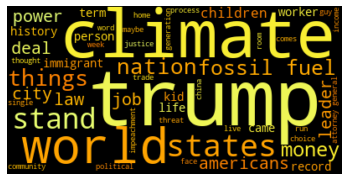

In [112]:
df_topic = df[df.topic == 5]
text_topic = " ".join(sentence for sentence in df_topic.sentence)

wordcloud = WordCloud(max_words=50, stopwords=my_stopwords, colormap="Wistia", random_state = 66).generate(text_topic)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("topic5_healthcare.png", format="png")
plt.show()

# Unite or divide?

In [113]:
df.groupby('topic').senti_comp.mean()

topic
0    0.067719
1    0.068880
2    0.086809
3    0.044236
4    0.068401
5    0.092419
Name: senti_comp, dtype: float64

In [114]:
sentiments = pd.DataFrame()
for name in df.speaker.unique(): 
    sentiments[name] = df[df.speaker==name].groupby('topic').senti_comp.mean()
sentiments

,Bernie Sanders,Michael Bloomberg,Pete Buttigieg,Elizabeth Warren,Tom Steyer,Joe Biden,Amy Klobuchar,Andrew Yang,Kamala Harris,Cory Booker,Tulsi Gabbard,Julian Castro,Beto O’Rourke
topic,,,,,,,,,,,,,
0,0.061034,-0.016750,0.058640,0.072933,-0.034073,0.065931,0.136827,0.055877,0.160546,0.081255,-0.049751,0.125069,-0.027555
1,0.079109,0.014705,0.115580,0.052805,0.054461,0.005402,0.093661,0.139554,0.024130,0.059675,0.068096,0.318376,0.084673
2,-0.014790,0.064545,0.103883,0.142902,0.055865,0.074620,0.143523,0.024306,0.191362,0.059051,-0.018570,0.097418,0.115826
3,-0.018819,-0.059632,0.012740,0.002563,0.069611,0.040352,0.144129,0.053901,0.117088,0.061840,-0.043228,0.259395,-0.011837
4,0.066449,0.015889,0.153589,0.030288,0.081953,0.048249,0.094927,0.137808,0.076746,-0.049063,-0.070524,0.151711,0.011931
5,0.081499,0.018396,0.053116,0.105907,0.063759,0.059639,0.155439,0.158386,0.145113,-0.013642,0.202548,0.089627,0.170302


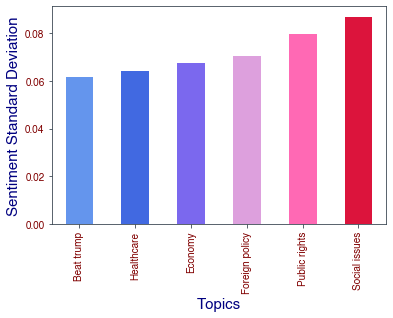

In [116]:
barplot = sentiments.std(axis = 1).sort_values().plot.bar(color=['cornflowerblue', 'royalblue', 
                                                                 'mediumslateblue', 'plum','hotpink', 'crimson'])
plt.ylabel('Sentiment Standard Deviation', fontsize = 15, weight = 'bold', color ='navy')
plt.xlabel('Topics', fontsize = 15, weight = 'bold', color = 'navy')
plt.xticks([0,1,2,3,4,5],['Beat trump', 'Healthcare','Economy','Foreign policy', 'Public rights', 'Social issues'], 
           color = 'maroon')
plt.yticks(color = 'maroon')
plt.savefig("unitedivide.png", format="png",bbox_inches='tight')
plt.show()

In [ ]:
0: beat trump
1: healthcare 
2: economy: job, tax, middle clas
3: foreign policy
4: public rights: justice system, woman right, climate change   
5: social issues: immigration, weapon control, minority, violence